In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from modcma.c_maes import (
    sampling,
    ModularCMAES, parameters, options, constants, utils, es
)



import matplotlib
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.transforms import Affine2D

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 15})

In [4]:
samplers = (
    sampling.CauchyTransformer,
    sampling.DoubleWeibullTransformer,
    sampling.GaussianTransformer,
    sampling.LaplaceTransformer,
    sampling.LogisticTransformer,
    sampling.UniformScaler,    
)


def get_sampler(d, transformer):
    base_sampler = sampling.Uniform(d)
    sampler = transformer(base_sampler)
    return sampler


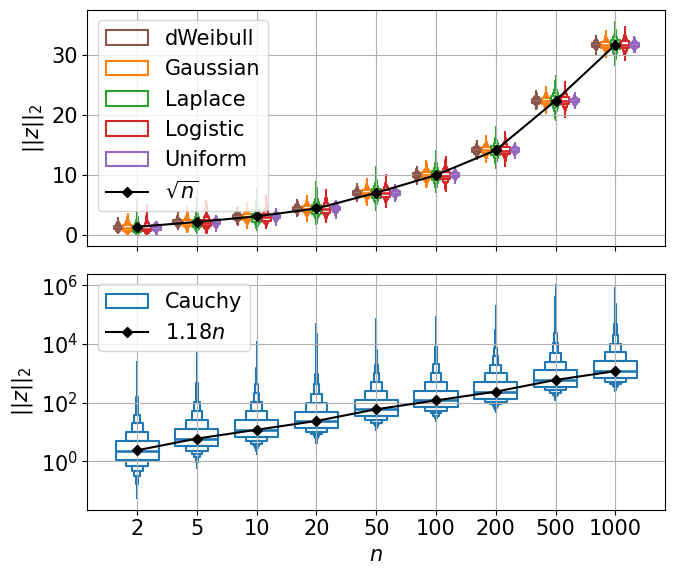

In [5]:
n_samples = 10000

def get_name(sampler_cls):
    return sampler_cls.__name__.replace("Transformer", "").replace("Scaler", "").replace("Double", "d")

records = []
dims = np.array((2, 5, 10, 20, 50, 100, 200, 500, 1000))
for i, (sampler_cls) in enumerate(samplers):
    for d in dims:
        sampler = get_sampler(d, sampler_cls)
        samples = [(get_name(sampler_cls), d, np.linalg.norm(sampler())) for _ in range(n_samples)]
        records.extend(samples)

colums = ["Sampler", r"$n$", r"$||z||_2$"]
data = pd.DataFrame(records, columns = colums)

palette = dict(zip(sorted(data['Sampler'].unique()), sns.color_palette("tab10")))

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
sns.boxenplot(data[data['Sampler'] != 'Cauchy'], x=colums[1], hue=colums[0], y=colums[2], fill=False, gap=.1, showfliers=False, ax=ax1, palette=palette)
ax1.plot(range(len(dims)), np.sqrt(dims), marker='D', markersize=5, label=r'$\sqrt{n}$', color='black')


ax1.legend()
ax1.grid()

sns.boxenplot(data[data['Sampler'] == 'Cauchy'], x=colums[1], hue=colums[0], y=colums[2], fill=False, gap=.1, showfliers=False, ax=ax2, palette=palette)
ax2.plot(range(len(dims)), 1.18 * dims, marker='D', markersize=5, label=r'1.18${n}$', color='black')
ax2.set_yscale("log")
ax2.legend(loc='upper left')
ax2.grid()
plt.tight_layout()
# plt.savefig("figures/distributions_z.pdf")


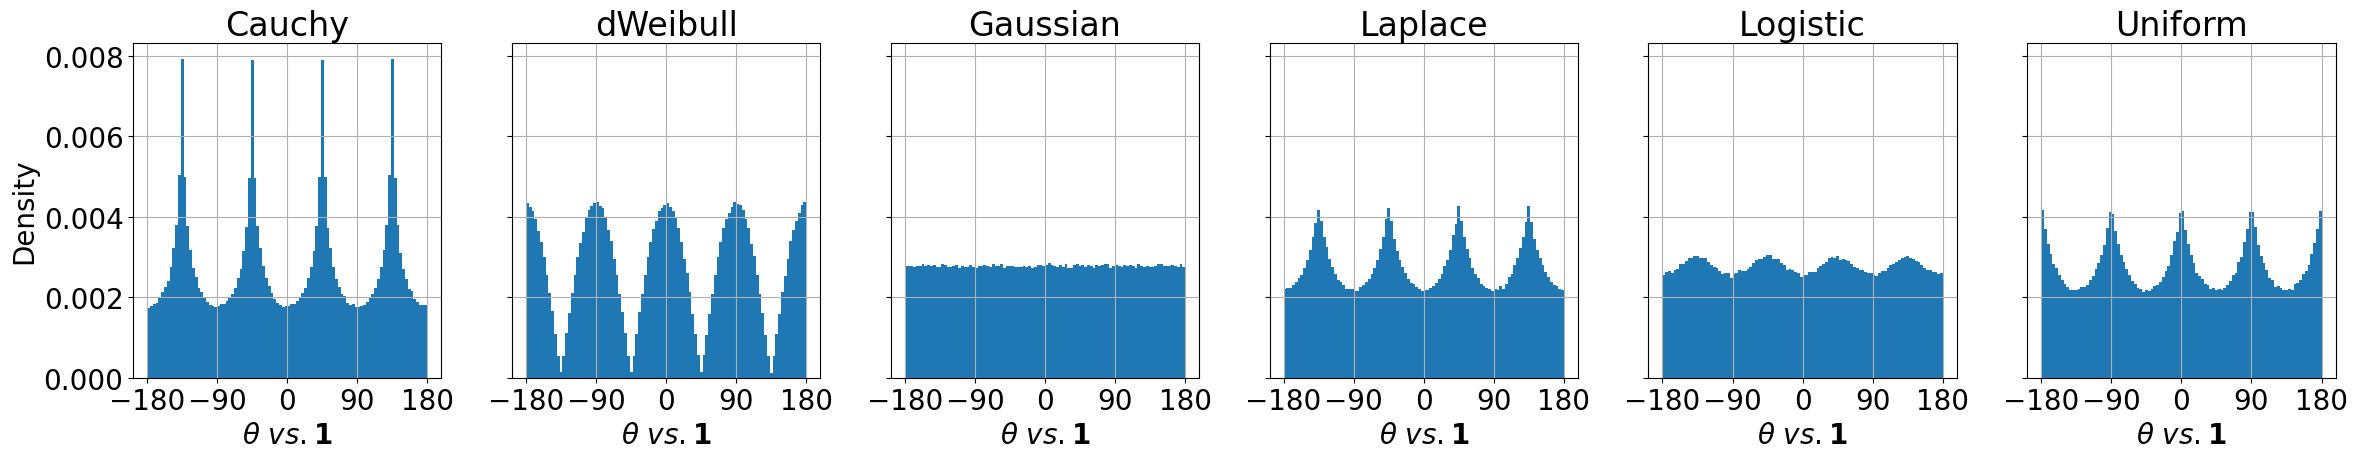

In [63]:
n_samples = 1000000
n = 2

matplotlib.rcParams.update({'font.size': 20})

def angle_with_all_ones(vector):
    # Convert input to a numpy array
    vector = np.array(vector)
    all_ones = np.ones_like(vector)
    dot_product = np.dot(vector, all_ones)

    # Compute the magnitudes
    magnitude_v = np.linalg.norm(vector)
    magnitude_ones = np.linalg.norm(all_ones)

    # Compute the cosine of the angle
    cos_theta = dot_product / (magnitude_v * magnitude_ones)

    # Ensure the value is within the valid domain for arccos [-1, 1] (handle numerical precision issues)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)

    # Compute the angle in radians and convert to degrees
    angle_radians = np.arccos(cos_theta)
    angle_degrees = np.degrees(angle_radians)
    
    clockwise = -np.sign(dot_product * np.cross(vector, all_ones))
    
    return angle_degrees * clockwise


f, axes = plt.subplots(1, 6, figsize=(4*len(samplers), 5), sharex=True, sharey='row')

axes[0].set_ylabel(r"Density")
for ax, sampler_cls in zip(axes.ravel(), samplers):
    sampler = get_sampler(n, sampler_cls)
    samples = np.array([sampler() for s in range(n_samples)]).T
    # samples = np.abs(samples)
    directions = samples / np.linalg.norm(samples, axis=0)
    angles2 = np.array([angle_with_all_ones(s) for s in directions.T]).ravel()
    
    ax.hist(angles2, bins=100, density=True)
    # ax.set_title(f"{get_name(sampler_cls)}: ({np.mean(angles2):.2f}+-{np.std(angles2):.2f})")
    ax.set_title(f"{get_name(sampler_cls)}")

    ax.grid()
    
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
    ax.set_xlabel(r"$\theta\ vs. \mathbf{1}$")
    ax.set_xticks(np.arange(-180, 181, 90))

plt.tight_layout()
plt.savefig(f"figures/angles_vs_unitvec_n{n}.pdf")


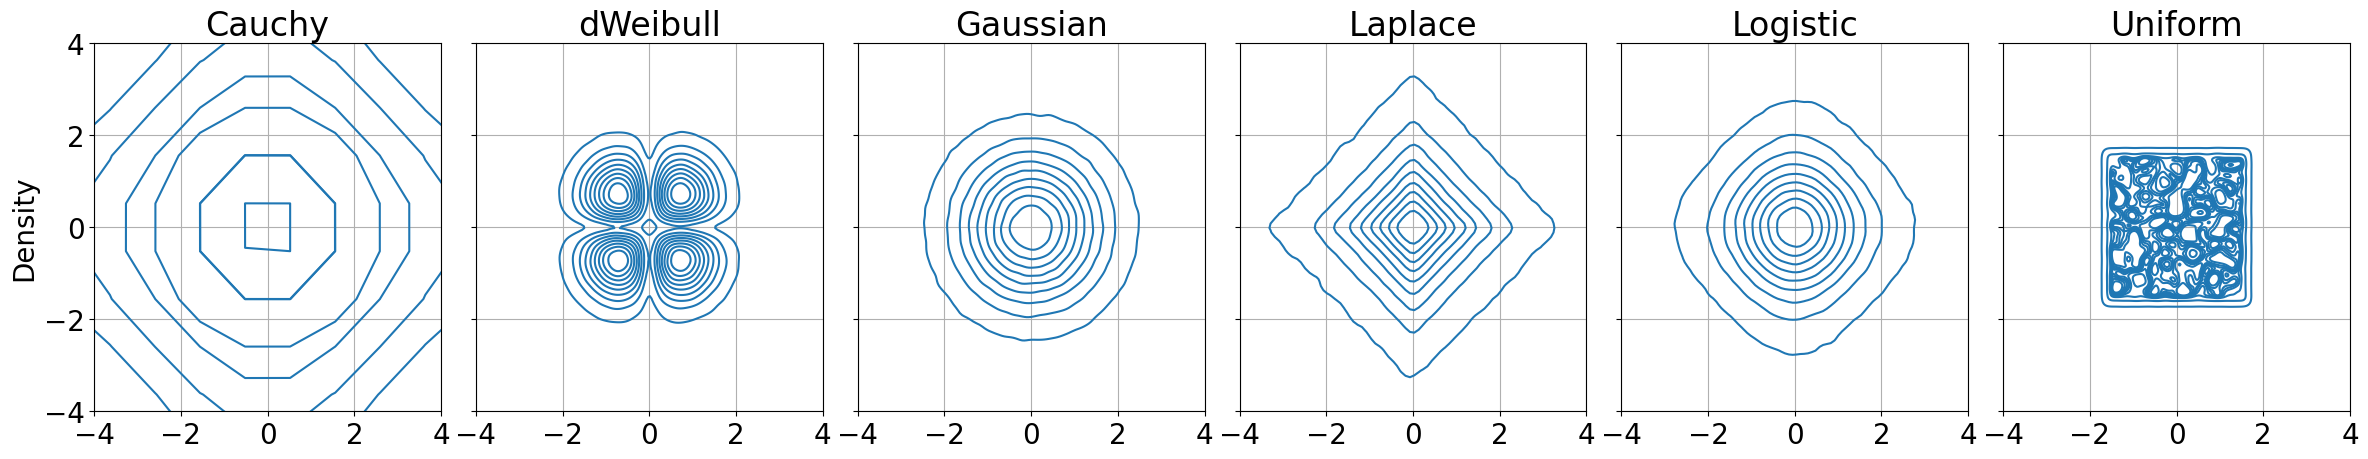

In [5]:
n_samples = int(10e5)
n = 2

matplotlib.rcParams.update({'font.size': 20})

f, axes = plt.subplots(1, len(samplers), figsize=(4*len(samplers), 5 * (2 - 1)), sharex=True, sharey='row')

axes[0].set_ylabel(r"Density")
for ax, sampler_cls in zip(axes.ravel(), samplers):
    sampler = get_sampler(n, sampler_cls)
    samples = np.array([sampler() for s in range(n_samples)]).T
    # samples = np.abs(samples)
    # directions = samples / np.linalg.norm(samples, axis=0)
    try:
        sns.kdeplot(x=samples[0].clip(-100, 100), y=samples[1].clip(-100, 100), ax=ax)
    except:
        continue
    ax.set_title(f"{get_name(sampler_cls)}")

    # ax.xaxis.set_tick_params(which='both', labelbottom=True)
    # ax.set_xlabel(r"$\theta\ vs. \mathbf{1}$")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.grid()

plt.tight_layout()

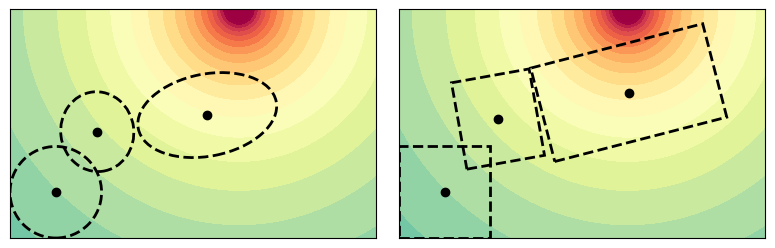

In [7]:
d = 2 

def sphere(x):
    x = np.asarray(x)
    return x.dot(x)

def get_meshgrid(objective_function, lb, ub, delta: float = 0.025):
    x = np.arange(lb, ub + delta, delta)
    y = np.arange(lb, ub + delta, delta)

    if hasattr(objective_function, "optimum"):
        xo, yo = objective_function.optimum.x
        x = np.sort(np.r_[x, xo])
        y = np.sort(np.r_[y, yo])

    X, Y = np.meshgrid(x, y)

    Z = np.zeros(X.shape)
    for idx1 in range(X.shape[0]):
        for idx2 in range(X.shape[1]):
            Z[idx1, idx2] = objective_function([X[idx1, idx2], Y[idx1, idx2]])
    return X, Y, Z


X, Y, Z = get_meshgrid(sphere, -5, 3)

x0 = np.array([-4, -4])


modules = parameters.Modules()
modules.sample_transformation = options.SampleTranformerType(1)
settings = parameters.Settings(dim=2, modules=modules, x0=x0, sigma0=2)

utils.set_seed(10)
cma = ModularCMAES(settings)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)

ax1.contourf(
    X, Y, np.log10(Z), levels=200, cmap="Spectral", zorder=-1, vmin=-1, vmax=2.5
)
ax2.contourf(
    X, Y, np.log10(Z), levels=200, cmap="Spectral", zorder=-1, vmin=-1, vmax=2.5
)

for i in range(3):
    m = cma.p.adaptation.m.copy()
    C = cma.p.adaptation.C.copy()
    sigma = cma.p.mutation.sigma
    theta = np.degrees(np.arctan2(C[1, 0], C[0, 0]))
    
    color = 'black'
    p = ax1.scatter(*m, label=i, color=color)
    
    current = Ellipse(
        m,
        *(sigma * np.diag(C)),
        angle=theta,
        facecolor="none",
        edgecolor=p.get_edgecolor(),
        linewidth=2,
        linestyle="dashed",
        zorder=0,
    )
    ax1.add_patch(current)
    cma.step(sphere)
    
    
    
modules = parameters.Modules()
modules.sample_transformation = options.SampleTranformerType(2)
settings = parameters.Settings(dim=2, modules=modules, x0=x0, sigma0=2)

utils.set_seed(10)
cma = ModularCMAES(settings)

for i in range(3):
    m = cma.p.adaptation.m.copy()
    C = cma.p.adaptation.C.copy()
    sigma = cma.p.mutation.sigma
    theta = np.degrees(np.arctan2(C[1, 0], C[0, 0]))
    
    color = 'black'
    p = ax2.scatter(*m, label=i, color=color)
    
    
    width = sigma * C[0, 0]
    height = sigma * C[1, 1]
    
    current = Rectangle(
       (-width / 2, -height / 2), width, height,
        facecolor="none",
        edgecolor=p.get_edgecolor(), 
        linewidth=2,
        linestyle="dashed",
        zorder=0,   
    )
    transformation = (
        Affine2D()
        .rotate_deg(theta)  
        .translate(*m)
        + ax2.transData  
    )
    
    current.set_transform(transformation)
    
    ax2.add_patch(current)
    cma.step(sphere)
    

for ax in ax1, ax2:
    ax.set_aspect("equal")
    ax.set_ylim(-5, 0)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
# plt.savefig("figures/adaptation.pdf")

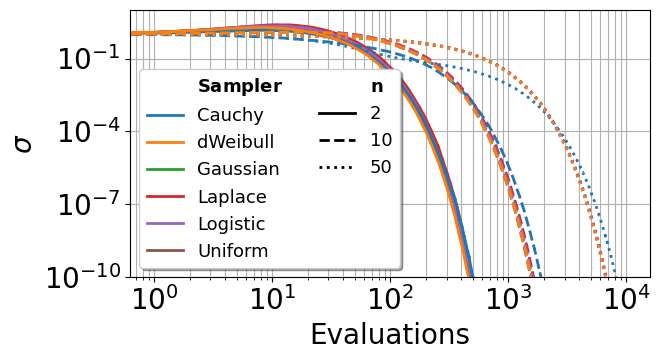

In [65]:
def get_one_plus_one(problem, dim, sampler):
    modules = parameters.Modules()
    modules.sample_transformation = options.SampleTranformerType(sampler)
    
    x0 = np.random.uniform(-5, 5, size=dim)
    return es.OnePlusOneES(
        dim,
        x0=x0,
        f0=problem(x0),
        sigma0=1,
        modules=modules,
    )
    
names = sorted([options.SampleTranformerType(sampler).name.title().replace("Scaled_", "").replace("Double_", "d") 
                for sampler in range(1, 7)], key=lambda x:x.lower())
colors = dict(zip(names, sns.color_palette("tab10")))

n_evals = 10000
n_runs = 1000

linestyle = {
    2: "solid",
    10: "dashed",
    50: "dotted"
}

np.random.seed(1)
utils.set_seed(1)
linewidth = 2

f, ax = plt.subplots(figsize=(7, 4))
for sampler in range(1, 7):
    for d in (2, 10, 50):
        f = np.zeros(n_evals)
        s = np.zeros(n_evals)
        for r in range(n_runs):
            alg = get_one_plus_one(sphere, d, sampler)
            for e in range(n_evals):
                f[e] += alg.f
                s[e] += alg.sigma
                alg.step(sphere)
        
        f /= n_runs
        s /= n_runs
        sampler_name = get_name(alg.sampler.__class__)
        ax.plot(s, color=colors[sampler_name], linestyle=linestyle[d], label=sampler_name, linewidth=linewidth)

ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")

from matplotlib.lines import Line2D

handles = [Line2D([0], [0], linestyle='')]
labels = ["$\\bf{Sampler}$"]

for alg, color in colors.items():
    handles.append(Line2D([0], [0], label=alg, color=color, linewidth=linewidth))
    labels.append(alg)


handles.append(Line2D([0], [0], linestyle=''))
labels.append("$\\mathbf{n}$")

for alg, color in linestyle.items():
    handles.append(Line2D([0], [0], label=alg, color='black', linestyle=color, linewidth=linewidth))
    labels.append(alg)

handles.append(Line2D([0], [0], linestyle=''))
labels.append("")      
handles.append(Line2D([0], [0], linestyle=''))
labels.append("")      

ax.legend(handles, labels, loc='lower left', fancybox=True, shadow=True, fontsize=13, ncol=2)
ax.set_ylim(1e-10, 10)
ax.grid(which="both", axis="both")
ax.set_ylabel(r"$\sigma$")
ax.set_xlabel(r"Evaluations")
plt.tight_layout()
# plt.savefig("figures/1p1_sigma.pdf")

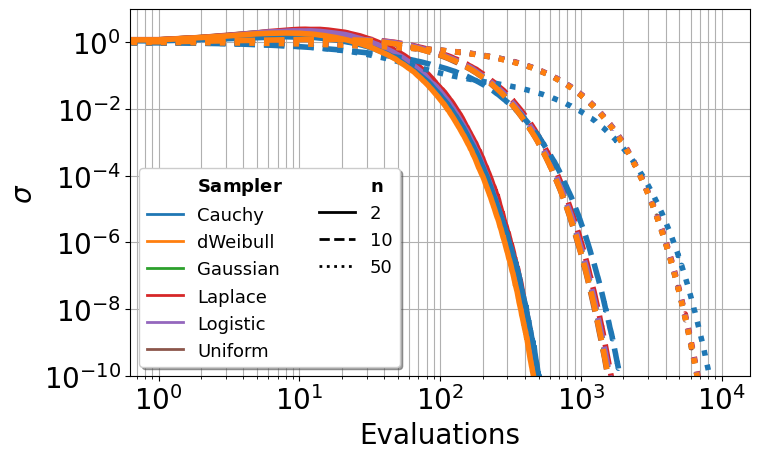

In [78]:
ax.figure.set_figwidth(8)
ax.figure.set_figheight(5)
for line in ax.lines:
    line.set_linewidth(4)
ax.figure.tight_layout()
ax.figure.savefig("figures/1p1_sigma_v2.pdf")

ax.figure

In [85]:
from scipy import stats
from time import perf_counter

samplers = [
    lambda a: stats.cauchy(2.0, scale=1).rvs(size=a),
    lambda a: stats.dweibull(2.0, scale=1).rvs(size=a),
    lambda a: stats.norm().rvs(size=a),
    lambda a: stats.laplace().rvs(size=a),
    lambda a: stats.logistic().rvs(size=a),
    lambda a: stats.uniform().rvs(size=a),
]

labels=["Cauchy", "dWeibull", "Gaussian",  "Laplace", "Logistic", "Uniform"]

def time_sampler(sampler, n = 1_000_000):
    start = perf_counter()
    sampler(n)
    return perf_counter() - start

# t = []
# for label, sampler in zip(labels, samplers):
#     times = [time_sampler(sampler) for _ in range(1000)]
#     t.append((label, np.mean(times), np.std(times)))
    
# time_data = pl.DataFrame(t, schema=['sampler', 'mean', 'std'], orient='row')

# time_sampler(samplers[2])

samplers[2](10**6).size

1000000

In [ ]:
plt.figure(figsize=(6, 3))
p = plt.errorbar(
    time_data['sampler'], time_data['mean'], time_data['std'], 
    marker='_', markersize=20, 
    capsize=5,
    markeredgewidth=2, 
    elinewidth=2, 
    linestyle=''
)


plt.grid()
plt.xticks(rotation=25);
plt.ylabel("Time [s]", color=p[0].get_color())
plt.yticks(color=p[0].get_color())
ax1 = plt.gca()
ax2 = plt.twinx()
g_time = time_data.filter(sampler='Gaussian')['mean'] 


ax2.plot(time_data['sampler'], (time_data['mean'] - g_time) / g_time, color='red', marker='x', linestyle='', markersize=7, markeredgewidth=2)

ax2.set_ylabel("vs. Gaussian", color='red')
ax2.plot(time_data['sampler'], np.zeros(6), linestyle='dashed', zorder=-100, color='grey')
plt.yticks(color='red')
ax2.set_ylim(*((np.array(ax1.get_ylim()) - g_time[0]) / g_time[0]))
plt.tight_layout()
plt.savefig("figures/time.pdf")